In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model,layers, regularizers

import numpy as np
import time
import pandas as pd
from matplotlib import pyplot as plt

# Constructing GAN
## Define loss
* Wasserstein loss
* JS divergence

In [ ]:
generator_encoded=keras.models.load_model("drive/MyDrive/GAN/generator_encoded_epoch300")
discriminator=keras.models.load_model("drive/MyDrive/GAN/discriminator_epoch300")

In [ ]:
wasserstein=True
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)
if wasserstein==False:

else:



## Generator

In [ ]:
#generator is our generator model
def make_generator(n_output, n_input = 100, hidden_widths = [128,128,128],minibatch_avg=True):
    ''' Make generator for data of data_dim number of fields. The input_dim represents the noise but could be used for style transfer.
    gen_hidden_widths are the widths of the hidden layers of the nn'''
    gen_input_layer = layers.Input(shape=(n_input,),name="GeneratorInput")
    gen_input_batch_norm=layers.BatchNormalization(name="GenBNInput")(gen_input_layer)


    gen_hidden_layers=[layers.Dense(units=hidden_widths[0],activation=tf.nn.relu,name="GenHiddenLayer0")(gen_input_batch_norm)]

    for i in range(1,len(hidden_widths)):
        gen_hidden_layers=gen_hidden_layers+[layers.BatchNormalization(name="GenBNLayer"+str(i))(gen_hidden_layers[-1])]
        gen_hidden_layers=gen_hidden_layers+[layers.Dense(units=hidden_widths[i],activation=tf.nn.leaky_relu,
                                                          name="GenHiddenLayer"+str(i))(gen_hidden_layers[-1])]
        gen_hidden_layers=gen_hidden_layers+\
        [layers.Add(name="GenSkipLayer"+str(i))((gen_hidden_layers[-1],gen_hidden_layers[-3]))]


    gen_output=layers.Dense(units=n_output,activation=tf.keras.activations.linear,
                                                          name="GenOutput")(gen_hidden_layers[-1])
    if(minibatch_avg):
        gen_output_avg=tf.reduce_mean(gen_output,axis=0,keepdims=True,name="GenOutputAverage")*\
        tf.ones(shape=tf.shape(gen_output))

        generator=tf.keras.Model(
            inputs=[gen_input_layer],
            outputs=[gen_output,gen_output_avg],
        )
        return generator
    else:
        generator=tf.keras.Model(
            inputs=[gen_input_layer],
            outputs=[gen_output],
        )
        return generator
        



In [ ]:
generator = make_generator(n_output = 1,n_input = 100, hidden_widths=[128])
tf.keras.utils.plot_model(generator, "images/generator_test_minibatch.png")
generator1 = make_generator(n_output = 1,n_input = 100, hidden_widths=[128],minibatch_avg=False)
tf.keras.utils.plot_model(generator1, "images/generator_test.png")

## Discriminator

In [ ]:
disc_hidden_widths=[128,256,256]
def make_discriminator(n_input, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True):
    if minibatch_avg:
        disc_input_layer=layers.Input(shape=(n_input,),name="DiscriminatorInput")
        disc_avg_input_layer=layers.Input(shape=(n_input,),name="DiscriminatorAverageInput")
        disc_allinput=layers.Concatenate(name="DiscriminatorAllInput")((disc_input_layer,
                                                                                    disc_avg_input_layer,
                                                                                   ))
    else:
        disc_allinput=layers.Input(shape=(n_input,),name="DiscriminatorAllInput")
    
    disc_hidden_layers=[layers.Dense(units=disc_hidden_widths[0],activation=tf.nn.leaky_relu,name="DiscHiddenLayer0")(disc_allinput)]

    for i in range(1,len(disc_hidden_widths)):
        disc_hidden_layers=disc_hidden_layers+\
        [layers.Dense(units=disc_hidden_widths[i],activation=tf.nn.leaky_relu,name="DiscHiddenLayer"+str(i))(disc_hidden_layers[-1])]
    if gan_type=="JS":
        disc_output=layers.Dense(units=1,activation=tf.nn.sigmoid,name="DiscriminatorOutput")(disc_hidden_layers[-1])
    if gan_type=="W":
        disc_output=layers.Dense(units=1,activation=tf.keras.activations.linear,name="DiscriminatorOutput")(disc_hidden_layers[-1])
    
    if minibatch_avg:
        discriminator=tf.keras.Model(
            inputs=[disc_input_layer,disc_avg_input_layer],
            outputs=[disc_output]
        )
        return discriminator
    else:
        discriminator=tf.keras.Model(
            inputs=disc_allinput,
            outputs=[disc_output]
        )
        return discriminator
        

In [ ]:
discriminator = make_discriminator(n_input=10, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True)
tf.keras.utils.plot_model(discriminator, "images/discriminator_test_minibatch.png")
discriminator1 = make_discriminator(n_input=10, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=False)
tf.keras.utils.plot_model(discriminator1, "images/discriminator_test.png")

# Discriminator and Generator Losses

In [ ]:
def w_discriminator_loss(real_output,fake_output):
    real_loss = -tf.reduce_mean(real_output)    #
    fake_loss = tf.reduce_mean(fake_output) #smaller 
    total_loss = real_loss + fake_loss
    return total_loss
def w_generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)
w_generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)
w_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=.5)

In [ ]:
#gradient penalty
def discriminator_gradient_penalty_ma(real_output,fake_output,discriminator):
    batch_shape=tf.shape(real_output)
    uniform_rand = tf.random.uniform(shape=batch_shape, maxval=1)
    mask_fake = uniform_rand #tf.math.greater(.5, uniform_rand)
    mask_fake = tf.cast(mask_fake,"float32")
    mask_real = (1.-mask_fake)
    mixed_real_fake = (mask_fake*fake_output[0] + mask_real*real_output[0],\
                               mask_fake*fake_output[1] + mask_real*real_output[1])
    with tf.GradientTape() as g:
        g.watch(mixed_real_fake)
        y = discriminator(mixed_real_fake)
    disc_gradient = g.gradient(y, mixed_real_fake)
    gradient_penalty = tf.reduce_mean(tf.square(
        tf.sqrt(tf.reduce_sum(tf.square(tf.concat(disc_gradient,axis=1)),axis=1))\
        - tf.ones(shape=(batch_shape[0],1))))
    return gradient_penalty


def discriminator_gradient_penalty(real_output,fake_output,discriminator):
    batch_shape=tf.shape(real_output)
    uniform_rand = tf.random.uniform(shape=batch_shape, maxval=1)
    mask_fake = uniform_rand #tf.math.greater(.5, uniform_rand)
    mask_fake = tf.cast(mask_fake,"float32")
    mask_real = (1.-mask_fake)
    mixed_real_fake = (mask_fake*fake_output[0] + mask_real*real_output,\
                               mask_fake*fake_output[1] + mask_real*real_output)
    with tf.GradientTape() as g:
        g.watch(mixed_real_fake)
        y = discriminator(mixed_real_fake)
    disc_gradient = g.gradient(y, mixed_real_fake)
    gradient_penalty = tf.reduce_mean(tf.square(
        tf.sqrt(tf.reduce_sum(tf.square(tf.concat(disc_gradient,axis=1)),axis=1))\
        - tf.ones(shape=(batch_shape[0],1))))
    return gradient_penalty

In [ ]:

discriminator((tf.random.normal((1,10)),tf.random.normal((1,10))))
discriminator_gradient_penalty((tf.random.normal((1,10)),tf.random.normal((1,10))),
                               (tf.random.normal((1,10)),tf.random.normal((1,10))),discriminator)


# Training loop for Generator Discriminator pair

In [ ]:
# This is meant to be a very general training step for systems of GAN
def train_step(generators, #dictionary string -> generator
               discriminators, #dictionary string -> discriminator
               real_data, #dictionary string for discriminator -> real data
               gen_objective, #dictionary string -> objective function
               disc_objective,
               gen_input,
               gen_optimizers,
               disc_optimizers, #dictionary string ->optimizer
               gen_num_steps,
               disc_num_steps#dictionary string -> number of steps
               ): 
    
    for gan, D in discriminators.items():
        G = generators[gan]
        real_batch = real_data[gan]
        for i in range(disc_num_steps[gan]):
            with tf.GradientTape() as D_tape:
                generated_batch = G(gen_input[gan], training = True)
                fake_disc_class = D(generated_batch, training=True)
                real_disc_class = D(real_batch, training=True)
                disc_obj = disc_objective[gan](real_batch, generated_batch)
            grad_D= D_tape.gradient(disc_obj, D.trainable_variables)
            disc_optimizers[gan].apply_gradients(zip(grad_D, D.trainable_variables))
        #print("discriminator objective ",disc_objective[gan](real_batch, generated_batch))
        
        for i in range(gen_num_steps[gan]):
            with tf.GradientTape() as G_tape:
                generated_batch = G(gen_input[gan], training = True)
                fake_disc_class = D(generated_batch, training=True)
                gen_obj = gen_objective[gan](real_batch,generated_batch,gen_input[gan])
            grad_G= G_tape.gradient(gen_obj, G.trainable_variables)
            gen_optimizers[gan].apply_gradients(zip(grad_G, G.trainable_variables))
        #print("generator objective ",gen_objective[gan](generated_batch))
 
                




# Tests

In [ ]:
#Let's test it out. GAN with minibatch
G = make_generator(n_output = 2,n_input = 10, hidden_widths=[128,128,128])
tf.keras.utils.plot_model(G0, "images/generator_training1.png")

D = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128,128],minibatch_avg=True)
tf.keras.utils.plot_model(D0, "images/discriminator_training1.png")


def D_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D(real_data),D(fake_data)) + discriminator_gradient_penalty_ma(real_data,fake_data,D)
def G_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D(fake_data))
test_data = tf.random.normal((5,2))
test_data = (test_data,
            tf.reduce_mean(test_data,axis = 0)*\
            tf.ones(shape = np.shape(test_data),dtype = "float32"))

test_noise= tf.random.normal((5,10))

print(G(test_noise))
print(D(test_data,G(test_noise)))






In [ ]:
gen_objective[gan](fake_disc_class)
fake_disc_class

In [ ]:
r = tf.convert_to_tensor(np.r_[
    np.random.normal([1,1],.2,size=(250,2)),
    np.random.normal([-1,1],.25,size=(250,2)),
    np.random.normal([1,-1],.25,size=(250,2)),
    np.random.normal([-1,-1],.25,size=(250,2))],dtype = "float32")
test_data = (r,
        tf.reduce_mean(r,axis = 0)*\
        tf.ones(shape = np.shape(r),dtype = "float32"))
real_data = {"GAN0" : test_data}
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(r[:,0],r[:,1],label="real data")

test_noise0= tf.random.normal((1000,10))
gen_data = G(test_noise0)
ax.scatter(gen_data[0][:,0],gen_data[0][:,1],label="synthetic data")


def D_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D(real_data),D(fake_data)) + discriminator_gradient_penalty_ma(real_data,fake_data,D)
def G_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D(fake_data))
print(D_OBJECTIVE(test_data,gen_data))

# Challenge 1. GAN makes mixture of gaussian from noise

In [ ]:
import imageio
import glob
n_input = 10
G = make_generator(n_output = 2,n_input = 10, hidden_widths=[64,64])
tf.keras.utils.plot_model(G0, "images/generator_training1.png")

D = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [64,64],minibatch_avg=True)
tf.keras.utils.plot_model(D0, "images/discriminator_training1.png")


def D_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D(real_data),D(fake_data)) + 100*discriminator_gradient_penalty_ma(real_data,fake_data,D)
def G_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D(fake_data))
plt.ioff()

d_losses=[]
g_losses=[]
d_objs = []
for i in range(100):
    r = tf.convert_to_tensor(np.r_[
    np.random.normal([1,1],.2,size=(250,2)),
    np.random.normal([-1,1],.25,size=(250,2)),
    np.random.normal([1,-1],.25,size=(250,2)),
    np.random.normal([-1,-1],.25,size=(250,2))],dtype = "float32")
    test_data = (r,
            tf.reduce_mean(r,axis = 0)*\
            tf.ones(shape = np.shape(r),dtype = "float32"))
    real_data = {"GAN0" : test_data}
    gen_input = {"GAN0": tf.random.normal((1000,n_input))}
    train_step(generators = {"GAN0" : G}, #dictionary string -> generator
                   discriminators = {"GAN0" : D}, #dictionary string -> discriminator
                   real_data = real_data, #dictionary string for discriminator -> real data
                   gen_objective = {"GAN0": G_OBJECTIVE}, #dictionary string -> objective function
                   disc_objective = {"GAN0" : D_OBJECTIVE},
                   gen_input = gen_input,
                   gen_optimizers = {"GAN0" : w_generator_optimizer},
                   disc_optimizers = {"GAN0" : w_discriminator_optimizer}, #dictionary string ->optimizer
                   gen_num_steps = {"GAN0" :1},
                   disc_num_steps = {"GAN0":5}#dictionary string -> number of steps
                  )
    if i%10 == 0:
        print("step "+str(i))
        f,ax = plt.subplots(figsize=(5,5))
        ax.scatter(r[:,0],r[:,1],label="real data")

        test_noise0= tf.random.normal((100,10))
        gen_data = G(test_noise0)
        ax.scatter(gen_data[0][:,0],gen_data[0][:,1],label="synthetic data")
        ax.legend()
        ax.set_xlim([-6,6])
        ax.set_ylim([-6,6])
        f.savefig("step"+str(i/10)+".png")
        d_losses = d_losses+[w_discriminator_loss(D(real_data["GAN0"]),D(G(gen_input["GAN0"])))]
        g_losses = g_losses +[w_generator_loss(G(gen_input["GAN0"]))]
        d_objs = d_objs + [D_OBJECTIVE(real_data["GAN0"],G(gen_input["GAN0"]))]
        print("disc loss:",w_discriminator_loss(D(real_data["GAN0"]),D(G(gen_input["GAN0"]))))
        print("gen_loss:",w_generator_loss(G(gen_input["GAN0"])))
    

In [ ]:
anim_file="gan.gif"        
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('step*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
f,ax = plt.subplots(figsize=(5,5))
ax.scatter(r[:,0],r[:,1],label="real data")

test_noise0= tf.random.normal((1000,10))
gen_data = G(test_noise0)
ax.scatter(gen_data[0][:,0],gen_data[0][:,1],label="synthetic data")
ax.legend()
f.savefig("optimizedgan.png")

In [ ]:
f,ax = plt.subplots(figsize=(10,5))
ax.plot(g_losses,label="generator loss")
ax.plot(d_losses,label="discriminator loss")
ax.plot(d_objs,label="discriminator loss+gradient penalty")
f.legend()
f.savefig("loss.png")

# Challenge 2 Train Style GAN for transforming the vertical noisy sin to the horizontal sin

In [ ]:
f,ax = plt.subplots (figsize=(10,10))
X_RAND1 = np.random.normal(0,2,1000)
Y_RAND1 = np.sin(X_RAND1*2)+np.random.normal(0,.1,1000)
ax.scatter(X_RAND1,Y_RAND1)

f,ax = plt.subplots (figsize=(10,10))
Y_RAND2 = np.random.normal(0,5,1000)
X_RAND2 = np.power(Y_RAND2,1)*np.sin(Y_RAND2)+np.random.normal(0,.5,1000)
ax.scatter(X_RAND2,Y_RAND2)

In [ ]:
G_hv = make_generator(n_output = 2,n_input = 2, hidden_widths=[128,128])
tf.keras.utils.plot_model(G0, "images/generator_cycle1.png")

D_hv = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128],minibatch_avg=True)
tf.keras.utils.plot_model(D0, "images/discriminator_cycle1.png")

G_vh = make_generator(n_output = 2,n_input = 2, hidden_widths=[128,128])
tf.keras.utils.plot_model(G0, "images/generator_cycle2.png")

D_vh = make_discriminator(n_input=2, gan_type = "W",hidden_widths = [128,128],minibatch_avg=True)
tf.keras.utils.plot_model(D0, "images/discriminator_cycle2.png")



def D_hv_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D_hv(real_data),D_hv(fake_data)) + 100*discriminator_gradient_penalty_ma(real_data,fake_data,D_hv)


def G_hv_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D_hv(fake_data))+ .05*(tf.reduce_mean(tf.losses.mae(G_vh(G_hv(gen_input)),gen_input)) + \
tf.reduce_mean(tf.losses.mae(G_hv(G_vh(real_data)),real_data)))

def D_vh_OBJECTIVE(real_data,fake_data):
    return w_discriminator_loss(D_vh(real_data),D_vh(fake_data)) + 100*discriminator_gradient_penalty_ma(real_data,fake_data,D_vh)


def G_vh_OBJECTIVE(real_data,fake_data,gen_input):
    return w_generator_loss(D_vh(fake_data)) + .05*tf.reduce_mean(tf.losses.mae(G_hv(G_vh(gen_input)),gen_input) + tf.losses.mae(G_vh(G_hv(real_data)),real_data))

generators = {"hv" : G_hv,"vh" : G_vh}
discriminators = {"hv" : D_hv,"vh" : D_vh}
gen_objective = {"hv" : G_hv_OBJECTIVE,"vh" : G_vh_OBJECTIVE}
disc_objective = {"hv" : D_hv_OBJECTIVE,"vh" : D_vh_OBJECTIVE}

In [ ]:
f, ax = plt.subplots(2,2,figsize=(10,10))
fake_h = G_vh(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2]))
ax[0,0].scatter(X_RAND1,Y_RAND1,label="real data")
ax[0,0].scatter(fake_h[0][:,0],fake_h[0][:,1],label="from v data")
ax[0,0].set_xlim([-6,6])
ax[0,0].set_ylim([-6,6])
ax[0,0].set_title("generate horizontal sin")

fake_v = G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1]))
ax[0,1].scatter(X_RAND2,Y_RAND2,label="real data")
ax[0,1].scatter(fake_v[0][:,0],fake_v[0][:,1],label="from h data")
ax[0,1].set_xlim([-12,12])
ax[0,1].set_ylim([-12,12])
ax[0,1].set_title("generate vertical sin")

fake_hvh = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1])))
ax[1,0].scatter(X_RAND1,Y_RAND1,label="real data")
ax[1,0].scatter(fake_hvh[0][:,0],fake_hvh[0][:,1],label="from cycle")
ax[1,0].set_xlim([-6,6])
ax[1,0].set_ylim([-6,6])
ax[1,0].set_title("horizontal sin cycle gen")

fake_vhv = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2])))
ax[1,1].scatter(X_RAND2,Y_RAND2,label="real data")
ax[1,1].scatter(fake_vhv[0][:,0],fake_vhv[0][:,1],label="from cycle")
ax[1,1].set_xlim([-12,12])
ax[1,1].set_ylim([-12,12])
ax[1,1].set_title("vertical sin cycle gen")

f.savefig("cycle"+str(i)+".png")

G_hv_OBJECTIVE(real_v,G_hv(real_h),real_h)
G_vh_OBJECTIVE(real_h,G_vh(real_v),real_v)

In [ ]:
real_h
#tf.reduce_mean(real_v,axis = 0)*tf.ones(shape = np.shape(real_v),dtype = "float32")
tf.reduce_mean(r,axis = 0)
#tf.ones(shape = np.shape(r),dtype = "float32")
real_v = tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2],dtype="float32")
tf.reduce_mean(real_v,axis = 0)*tf.ones(shape = np.shape(real_v),dtype = "float32")

In [ ]:
dhv_losses=[]
dvh_losses=[]
ghv_losses=[]
gvh_losses=[]
plt.ioff()
for i in range(10000):
    X_RAND1 = np.random.normal(0,2,1000)
    Y_RAND1 = np.sin(X_RAND1*2)+np.random.normal(0,.1,1000)
    real_h = tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1],dtype="float32")
    Y_RAND2 = np.random.normal(0,5,1000)
    X_RAND2 = np.power(Y_RAND2,1)*np.sin(Y_RAND2)+np.random.normal(0,.5,1000)
    real_v = tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2],dtype="float32")
    gen_input = {"hv" : real_h, "vh": real_v}
    real_data = {"hv": (real_v, tf.reduce_mean(real_v,axis = 0)*\
                tf.ones(shape = np.shape(real_v),dtype = "float32")),
                "vh": (real_h, tf.reduce_mean(real_h,axis = 0)*\
                tf.ones(shape = np.shape(real_h),dtype = "float32"))}
    #Step 1. Convert h to v
    #Step 2. Convert v to h
    
    train_step(generators = generators, #dictionary string -> generator
                   discriminators = discriminators, #dictionary string -> discriminator
                   real_data = real_data, #dictionary string for discriminator -> real data
                   gen_objective = gen_objective, #dictionary string -> objective function
                   disc_objective = disc_objective,
                   gen_input = gen_input,
                   gen_optimizers = {"hv" : w_generator_optimizer, "vh":w_generator_optimizer },
                   disc_optimizers = {"hv" : w_discriminator_optimizer, "vh" : w_discriminator_optimizer}, #dictionary string ->optimizer
                   gen_num_steps = {"hv":1,"vh":1},
                   disc_num_steps = {"hv":5,"vh":5}#dictionary string -> number of steps
                  )
    if i%10 == 0:
        
        dhv_losses = dhv_losses+[w_discriminator_loss(D_hv(real_data["hv"]),D_hv(G_hv(gen_input["hv"])))]
        dvh_losses = dvh_losses+[w_discriminator_loss(D_vh(real_data["vh"]),D_vh(G_vh(gen_input["vh"])))]
        ghv_losses = ghv_losses +[w_generator_loss(G_hv(gen_input["hv"]))]
        gvh_losses = gvh_losses +[w_generator_loss(G_vh(gen_input["vh"]))]

        print("disc hv loss:",w_discriminator_loss(D_hv(real_data["hv"]),D_hv(G_hv(gen_input["hv"]))))
        print("disc vh loss:",w_discriminator_loss(D_vh(real_data["vh"]),D_hv(G_vh(gen_input["vh"]))))
        print("gen vh loss:",w_generator_loss(G_vh(gen_input["vh"])))
        print("gen hv loss:",w_generator_loss(G_hv(gen_input["hv"])))
        
        f, ax = plt.subplots(2,2,figsize=(10,10))
        fake_h = G_vh(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2]))
        ax[0,0].scatter(X_RAND1,Y_RAND1,label="real data")
        ax[0,0].scatter(fake_h[0][:,0],fake_h[0][:,1],label="from v data")
        ax[0,0].set_xlim([-6,6])
        ax[0,0].set_ylim([-6,6])
        ax[0,0].set_title("generate horizontal sin")

        fake_v = G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1]))
        ax[0,1].scatter(X_RAND2,Y_RAND2,label="real data")
        ax[0,1].scatter(fake_v[0][:,0],fake_v[0][:,1],label="from h data")
        ax[0,1].set_xlim([-12,12])
        ax[0,1].set_ylim([-12,12])
        ax[0,1].set_title("generate vertical sin")

        fake_hvh = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND1,Y_RAND1])))
        ax[1,0].scatter(X_RAND1,Y_RAND1,label="real data")
        ax[1,0].scatter(fake_hvh[0][:,0],fake_hvh[0][:,1],label="from cycle")
        ax[1,0].set_xlim([-6,6])
        ax[1,0].set_ylim([-6,6])
        ax[1,0].set_title("horizontal sin cycle gen")

        fake_vhv = G_vh(G_hv(tf.convert_to_tensor(np.c_[X_RAND2,Y_RAND2])))
        ax[1,1].scatter(X_RAND2,Y_RAND2,label="real data")
        ax[1,1].scatter(fake_vhv[0][:,0],fake_vhv[0][:,1],label="from cycle")
        ax[1,1].set_xlim([-12,12])
        ax[1,1].set_ylim([-12,12])
        ax[1,1].set_title("vertical sin cycle gen")

        f.savefig("cycle"+str(i)+".png")

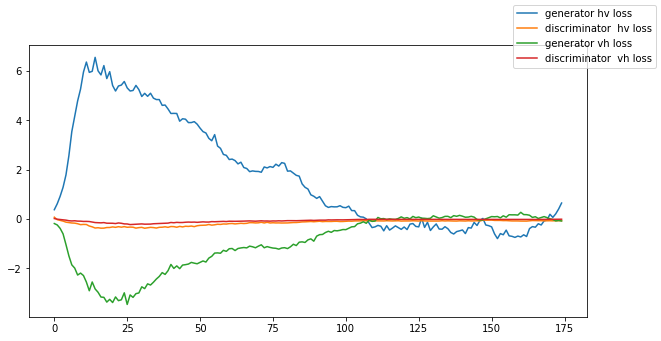

In [282]:
f,ax = plt.subplots(figsize=(10,5))
ax.plot(ghv_losses,label="generator hv loss")
ax.plot(dhv_losses,label="discriminator  hv loss")
ax.plot(gvh_losses,label="generator vh loss")
ax.plot(dvh_losses,label="discriminator  vh loss")

f.legend()
f.savefig("cycleloss.png")

In [281]:
anim_file="cyclegan_needs_work_lol.gif"        
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('cycle*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

FileNotFoundError: No such file: 'C:\Users\cmentus\Documents\GitHub\GenerativeModels\step99.0.png'

# Challenge 3. Importance sampling GAN: Control = striped distribution. Test= Mixture of Gaussians.